<h1>🤖 MLAI Workshop #03</h1>

<h2>Agenda</h2>

0.   Summary of previous workshops:
1.   Problem formulation in machine learning.
2.   Alternative

---

<h2>Section 0. Previously On...</h2>

<h3>Section 0A. The Learning Problem</h3>

In the first workshop we introduced the concept of the hypothesis, dataset, and optimization spaces - we explored how each of these influence the final solution $\hat{f}$ we obtain. We spent most of the workshop using hand-crafted hypothesis spaces.

<div align="center">
    <img src="https://github.com/nextgenerationgraduatesprogram/nextgen25-mlai-workshop03/blob/main/notebooks/...?raw=1" height="400"/>
    <p><em>Figure 1. Illustration of the hypothesis, dataset, optimization, and target spaces considered in the learning problem.</em></p>
</div>


<h3>Section 0B. Universal Function Approximation</h3>

In the second workshop we started to address the challenges of using a hand-crafted hypothesis space, explored how we could design universal function approximators, and gained some experience training simple multi-layer perceptrons.

> Our final solution is a function of the Hypothesis, Dataset, and Optimization


In [116]:
import torch

# observe some data using a noisy observation process
def observe_noisy(f, x):
  # Input noise ~ N(mean=0.05, std=0.02)
  x_noise = torch.randn_like(x) * 0.02 + 0.05
  x_measure = x + x_noise

   # Evaluate the (noisy) inputs
  y_pred = f(x_measure)

  # Output noise ~ N(mean=-0.05, std=0.08)
  y_noise = torch.randn_like(y_pred) * 0.08 - 0.05
  y_obs = y_pred + y_noise

  return y_obs

In [117]:
from typing import Callable

# create a dataset
class Dataset:
  def __init__(self, f: Callable, a: float, b: float, N: int = 100):
    super(Dataset, self).__init__()

    # Sample x uniformly in [a, b], shape [N,1]
    self.x = torch.rand(N, 1) * (b - a) + a

    # Observe f(x) through noise process, also [N,1]
    self.y = observe_noisy(f, self.x)

Text(0, 0.5, 'y_obs')

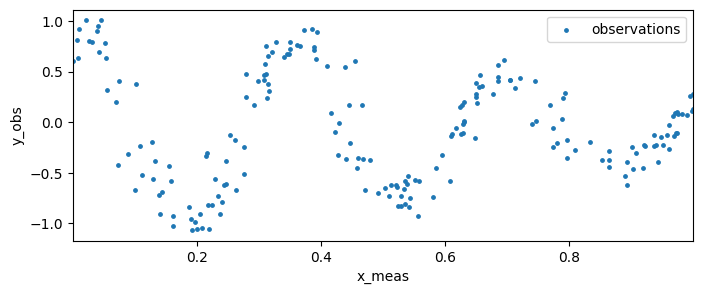

In [118]:
import matplotlib.pyplot as plt

# define a target function i.e. your data generating process
f = lambda x: torch.exp(-x**2) * torch.sin(5.8 * torch.pi * x + 0.41)

# define a dataset with your function
dataset = Dataset(f, a=0, b=1, N=200)

# visualize the observations
fig, ax = plt.subplots(figsize=(8,3))
ax.scatter(dataset.x, dataset.y, s=6, label="observations")
ax.set_xlim(dataset.x.min(), dataset.x.max())
ax.legend(loc="best")
ax.set_xlabel("x_meas")
ax.set_ylabel("y_obs")

In [119]:
import torch.nn as nn

# define a layer of perceptrons as a building block
class PerceptronLayer(nn.Module):
  def __init__(self, input_dim: int, output_dim: int, act: bool = True):
    super(PerceptronLayer, self).__init__()
    self.fc = nn.Linear(input_dim, output_dim)
    self.act = nn.ReLU() if act else nn.Identity()

  def forward(self, x):
    x = self.act(self.fc(x))
    return x

# create a flexible hypothesis space using an MLP
class MultiLayerPerceptron(nn.Module):
  def __init__(self, hidden_layers: int = 0, hidden_dim: int = 1, input_dim: int = 1, output_dim: int = 1):
    super(MultiLayerPerceptron, self).__init__()
    modules = [PerceptronLayer(input_dim, hidden_dim)] # input layer
    for _ in range(hidden_layers): modules.append(PerceptronLayer(hidden_dim, hidden_dim)) # hidden layers
    modules.append(PerceptronLayer(hidden_dim, output_dim, act=False)) # output layer (no activation)
    self.layers = nn.ModuleList(modules) # store layers

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

In [120]:
from tqdm import tqdm

# define a training loop
def training_loop(model, optimizer, loss_fn, dataset, steps):
  losses = []
  with tqdm(range(steps)) as pbar:
    for idx in pbar:
      optimizer.zero_grad()
      y_pred = model(dataset.x)
      loss = loss_fn(dataset.y, y_pred)
      losses.append(loss)
      loss.backward()
      optimizer.step()
      pbar.set_description(f"loss: {loss.item():.3f}")
    return model, torch.tensor(losses)

# define some functions for plotting our results
def plot_loss_curve(losses):
    fig, ax = plt.subplots(figsize=(8,3))
    ax.plot(losses, label="loss")
    ax.set_xlim(left=0, right=len(losses)-1)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss (MSE)")
    ax.set_title("Loss Curve")
    ax.grid(True, alpha=0.50)
    ax.legend()
    return fig, ax

def plot_predictions(model, dataset, ax = None):
    if ax is None: fig, ax = plt.subplots(figsize=(8,3))
    with torch.no_grad():
        ax.scatter(dataset.x, model(dataset.x), s=4, label="predictions")
        ax.scatter(dataset.x, dataset.y, s=4, label="observations")
    ax.set_xlim(left=dataset.x.min(), right=dataset.x.max())
    ax.grid(True, alpha=0.50)
    ax.legend(loc="best")
    return ax

When training our models we generally want our setup to have several properties:


1.   We want the dataset to sufficiently represent the data generating process.
2.   We want the hypothesis space to be large enough to accurately approximate the dataset.
3.   We need our optimizer to be capable of finding a suitable set of solutions.



In [121]:
# train a model
dataset = Dataset(f, a=0, b=1, N=200)
model = MultiLayerPerceptron(hidden_layers=0, hidden_dim=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_fn = torch.nn.MSELoss()
model, losses = training_loop(model, optimizer, loss_fn, dataset, steps=500)

loss: 0.155: 100%|██████████| 500/500 [00:01<00:00, 332.69it/s]


<Axes: >

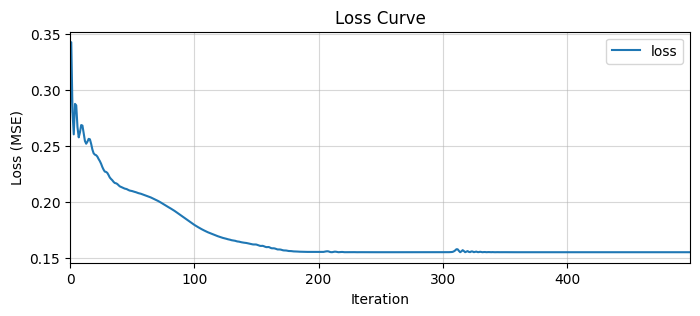

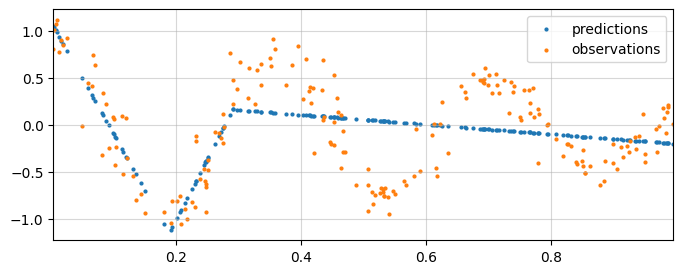

In [122]:
plot_loss_curve(losses)
plot_predictions(model, dataset)

<h3>Section 0C. Interpolation Error</h3>

We also investigated some of the challenges inherent in learning from data in terms of interpolation and extrapolation performance. We saw that our interpolation error is typically bounded by our ability to resolve changes in the data manifold.

loss: 0.044: 100%|██████████| 500/500 [00:02<00:00, 213.89it/s]


(0.0, 1.0)

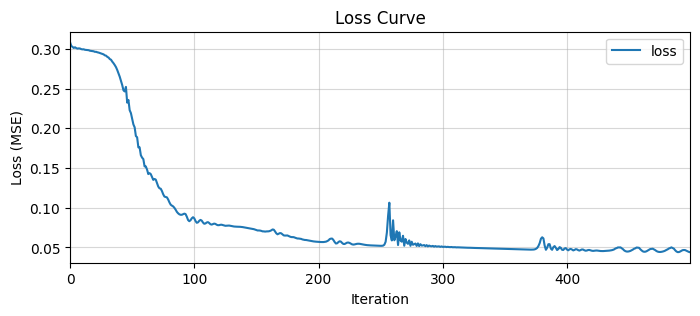

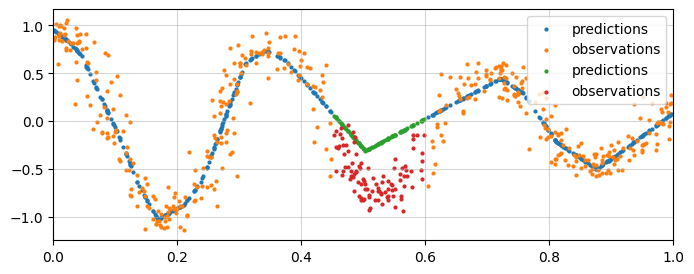

In [123]:
# define your domain
dataset = Dataset(f, a=0, b=1, N=500)

# lets explore how well it interpolates by erasing a region
x_min, x_max = 0.45, 0.60
keep_idxs = (dataset.x < x_min) | (dataset.x > x_max)
dataset.x = dataset.x[keep_idxs].unsqueeze(-1)
dataset.y = dataset.y[keep_idxs].unsqueeze(-1)

# train a model
model = MultiLayerPerceptron(hidden_layers=2, hidden_dim=30) # 0 hidden layers / 1 perceptrons
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()
model, losses = training_loop(model, optimizer, loss_fn, dataset, steps=500)

# plot the results
plot_loss_curve(losses)
ax = plot_predictions(model, dataset)

# see how well it interpolates
dataset_interp = Dataset(f, a=x_min, b=x_max, N=100)
ax = plot_predictions(model, dataset_interp, ax)
ax.set_xlim(0, 1)

<h3>Section 0D. Extrapolation Error</h3>

Extending this to extrapolation (data outside the convex hull of the training distribution), without data to constrain the behaviour of the function the model typically exhibited poor generalization.

For perfect generalization we would require our network to have learned the function governing the data generating process; this is typically a tall-order for extremely flexible hypothesis spaces. The representational capacity of neural networks is typically focussed on resolving the curvature of the dataset manifold - with more suitably constrained hypothesis spaces (i.e. different inductive biases inherent in our choice of architecture) we may be able to enforce some stronger generalization garuntees.

(-0.5, 1.5)

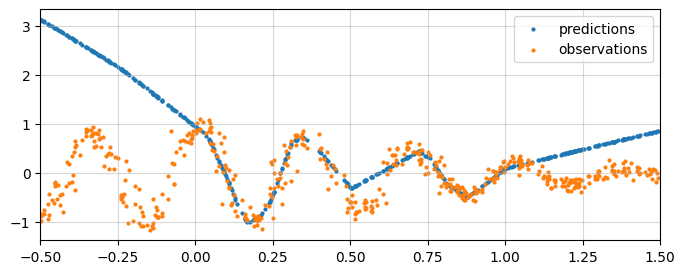

In [124]:
# define a much broader domain to see how well it extrapolates
dataset_extrap = Dataset(f, -0.5, 1.5, 500)

# plot the results
ax = plot_predictions(model, dataset_extrap)
ax.set_xlim(-0.5, 1.5)

To remind ourselves of what our multi-layer perceptron is doing, we can investigate the activations of individual neurons. By examining how these units respond to inputs, we begin to uncover the hierarchical feature representations the model is constructing during learning.









In [125]:
# lets explore the model
model

MultiLayerPerceptron(
  (layers): ModuleList(
    (0): PerceptronLayer(
      (fc): Linear(in_features=1, out_features=30, bias=True)
      (act): ReLU()
    )
    (1-2): 2 x PerceptronLayer(
      (fc): Linear(in_features=30, out_features=30, bias=True)
      (act): ReLU()
    )
    (3): PerceptronLayer(
      (fc): Linear(in_features=30, out_features=1, bias=True)
      (act): Identity()
    )
  )
)

In [126]:
# store
activations = {}

# define a forward pass hook to grab the outputs
def make_hook(name):
  def hook(module, input, output):
    # detach to avoid keeping the full graph
    activations[name] = output.detach().cpu()
  return hook

# register model hooks to the ReLU outputs
for idx, layer in enumerate(model.layers):
  if not layer.act._forward_hooks:
    layer.act.register_forward_hook(make_hook(f"layer_{idx}_relu"))

# run a forward pass on region to populate activations
x = torch.linspace(-1, 2, steps=1000).unsqueeze(-1)
_ = model(x)

(-1.0, 2.0)

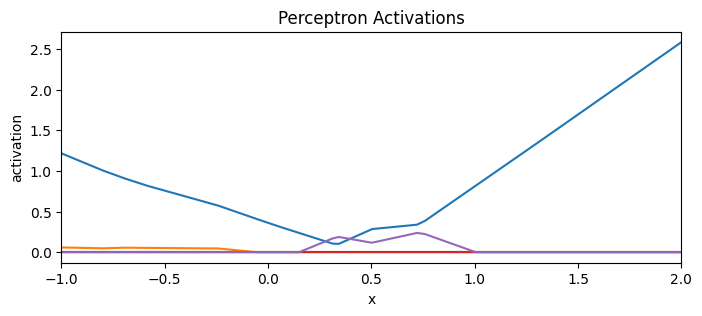

In [127]:
# which perceptron to inspect
layer_index = 1
perceptron_indexes = [0, 1, 2, 3, 4]

# acts is of shape [N, output_dim]
fig, ax = plt.subplots(figsize=(8,3))
for perceptron_index in perceptron_indexes:
  ax.plot(x, activations[f"layer_{layer_index}_relu"][:,perceptron_index], label=f"layer_{layer_index}_relu:{perceptron_index}")
ax.set_title(f"Perceptron Activations")
ax.set_xlabel("x")
ax.set_ylabel("activation")
ax.set_xlim(x.min(), x.max())

---

<h2>Section 1. Up Next... Problem Formulation</h2>

So far, we've developed a framework for flexible function approximation, and explored how factors like model capacity, data distribution, and optimization dynamics influence the solutions we learn.

In this workshop, we'll explore how to apply this approach to function approximation to different problem settings. Specifically, we'll examine how the structure and representation of our learning task impacts the solutions we can learn, the nature of the task itself, and informs the choice of hypothesis space.

We explore this in the following stages:
1.   Define a goal.
2.   Formulate the learning problem - what are we trying to predict?
3.   How should we represent the input?
3.   How should we design our hypothesis space?
4.   Train, evaluate, and analyse the results.


<h3>Section 1A. Goal - Spiral Arm Classification</h3>

For a given problem setting, the way we structure the learning task has a significant impact. In earlier examples, we explored problems of the form:

\begin{align*}
  f: \mathcal{X} \to \mathcal{Y} \tag{1.1}\\
\end{align*}

where $\mathcal{X} \in \mathbb{R}^{1}$ and $\mathcal{Y} \in \mathbb{R}^{1}$. This reflects a simple one-dimensional regression task which is useful for building intuition about aspects of the learning problem.

Let's instead consider the problem setting of classifying the arms of a spiral dataset...

In [128]:
import torch
import numpy as np

class SpiralDataset():
  """
  Generates a 2D spiral dataset with two arms (binary classification).
  Returns:
      x: Tensor of shape [2N, 2]
      y: Tensor of shape [2N] with labels 0 or 1
  """
  def __init__(self, N: int = 100, noise: float = 0.2, ratio: float = 1.0):
    # angle
    theta = ratio * 1.5 * np.sqrt(np.random.rand(N)) * 2 * np.pi
    r_a = 2 * theta + np.pi / 2
    r_b = -2 * theta - np.pi / 2

    # Spiral A (label 0)
    x_a = np.stack([np.cos(theta) * r_a, np.sin(theta) * r_a], axis=1)
    x_a += np.random.randn(N, 2) * noise
    y_a = np.zeros(N)

    # Spiral B (label 1)
    x_b = np.stack([np.cos(theta) * r_b, np.sin(theta) * r_b], axis=1)
    x_b += np.random.randn(N, 2) * noise
    y_b = np.ones(N)

    # format
    x = np.concatenate([x_a, x_b], axis=0)
    y = np.concatenate([y_a, y_b], axis=0)
    self.x = torch.tensor(x, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # for BCE loss

  def __len__(self) -> int:
    return self.x.shape[0]

  def __getitem__(self, index: int) -> tuple:
    return self.x[index], self.y[index]


# define the dataset
dataset = SpiralDataset(N=200, noise=0.2)

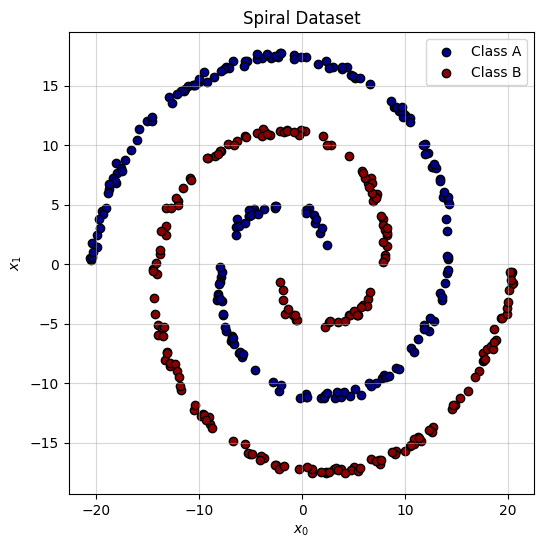

In [129]:
import matplotlib.pyplot as plt

# visualize the dataset
fig, ax = plt.subplots(figsize=(6,6))

# Class A
mask0 = dataset.y.squeeze() == 0
ax.scatter(dataset.x[mask0, 0], dataset.x[mask0, 1], color="darkblue", label="Class A", edgecolor="black")

# Class B
mask1 = dataset.y.squeeze() == 1
ax.scatter(dataset.x[mask1, 0], dataset.x[mask1, 1], color="darkred", label="Class B", edgecolor="black")

ax.set_title("Spiral Dataset")
ax.grid(True, alpha=0.50)
ax.set_xlabel(r"$x_{0}$")
ax.set_ylabel(r"$x_{1}$")
ax.legend(loc="best")

We can investigate the structure of this dataset and observe that we have $400$ samples, and each sample consists of:

\begin{align*}
  x \in \mathbb{R}^{2}, \quad y \in \{0, 1\}
\end{align*}

where $x = (x_{0}, x_{1})$ represents the position of a sample in cartesian coordinates and $y \in \{0, 1\}$ represents the class label of the position i.e. spiral A (class label 0) or B (class label 1).

In [130]:
# how is the data stored?
print(f"x shape: {dataset.x.shape}, dtype: {dataset.x.dtype}")
print(f"y shape: {dataset.y.shape}, dtype: {dataset.y.dtype}")
print("")

# what does a single sample look like?
print(f"X_0 = (x_0, x_1) = {dataset.x[0]}")
print(f"Y_0 = {dataset.y[0]}")

x shape: torch.Size([400, 2]), dtype: torch.float32
y shape: torch.Size([400, 1]), dtype: torch.float32

X_0 = (x_0, x_1) = tensor([1.7204, 2.5806])
Y_0 = tensor([0.])


<h3>Section 1B. What are we trying to predict?</h3>

We are given the goal to classify the spiral arms in our dataset. The first question to ask is:

> What do we want our model to learn - and why?

There are many valid ways to formulate a learning problem, even with the same data - different formulations represent slight different objectives and interpretations of the problem:

*   Do you want to predict which class a point belongs to? This is a very direct formulation.
*   Do you want to predict the probability that a point belongs to each class? This probabilistic output allows us to assess confidence and build more interpretable or robust systems.
*   Do you want to predict the signed distance to the decision boundary? This provides both classification and geometric insights into the data structure.
*   Do you want to predict the polar (angular) coordinate of a point? This provides a structural representation of the curve - that we could also use for classification.
*   Do you want to learn to reconstruct the input or discover its latent structure? This allows the model to uncover intrinsic geometry without needing labels, and supports tasks like clustering or generation.

Each approach uses the same data and achieves the same goal but approaches it in a slightly different manner.

> 💡 Choosing the right formulation is a design decision — one that aligns your learning system with the actual goal you care about.

📌 Let's assume we want to directly predict which class a point belongs to - hard classification. We want some function $f$, that takes in some input $x$, that directly predicts the class label $y \in \{0, 1\}$:

\begin{align*}
  f: x \in ... \mapsto y \in \{0, 1\}
\end{align*}

In [131]:
# our dataset is already stored in this format
dataset.y.shape

torch.Size([400, 1])

In [132]:
torch.unique(dataset.y)

tensor([0., 1.])

💬 *What is your goal? How have your formulated your learning problem - what specifically are you trying to predict?*

<h3>Section 1C. How should we structure our inputs?</h3>

With a clear problem formulation in place, the next decision to make is: how should we represent the input and output data for the model? This is a critical step in the design of machine learning systems that bakes in strong assumptions about:

*   What kind of structure we believe the data has.
*   What kind of operations we want the model to learn.
*   What biases we want to encode into the hypothesis space.

The same underlying data can be represented in many different ways:

*   A rasterized image, where we discretize the input space into a grid.
*   A point cloud, where each point is a 2D coordinate in continuous space.
*   A graph, where edges might encode spatial or similarity relationships.
*   A sequence, where each point links to a subsequent point.

Each representation encodes different assumptions about the structure of the data.

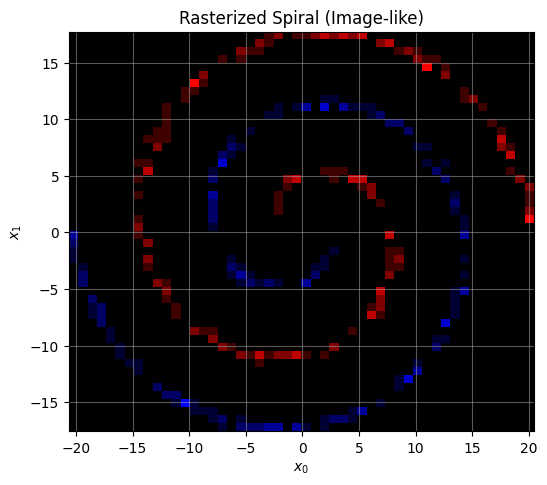

In [133]:
# rasterize the data
def rasterize_by_class(X, y, bins=100):
    x0_min, x0_max = X[:,0].min(), X[:,0].max()
    x1_min, x1_max = X[:,1].min(), X[:,1].max()

    # Separate class 0 and class 1
    X0 = X[y.squeeze() == 0]
    X1 = X[y.squeeze() == 1]

    hist0, _, _ = np.histogram2d(X0[:,0], X0[:,1], bins=bins, range=[[x0_min, x0_max], [x1_min, x1_max]])
    hist1, _, _ = np.histogram2d(X1[:,0], X1[:,1], bins=bins, range=[[x0_min, x0_max], [x1_min, x1_max]])

    # Normalize histograms to [0,1] for color intensity
    hist0 /= hist0.max()
    hist1 /= hist1.max()

    # Combine into RGB image: Red for class 1, Blue for class 0
    rgb = np.zeros((bins, bins, 3))
    rgb[..., 0] = hist1.T  # Red channel
    rgb[..., 2] = hist0.T  # Blue channel

    return rgb, (x0_min, x0_max, x1_min, x1_max)

# rasterize
rgb, extent = rasterize_by_class(dataset.x, dataset.y, bins=50)

# plot image
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(rgb, extent=extent)
ax.set_title("Rasterized Spiral (Image-like)")
ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")
ax.grid(True, alpha=0.50)


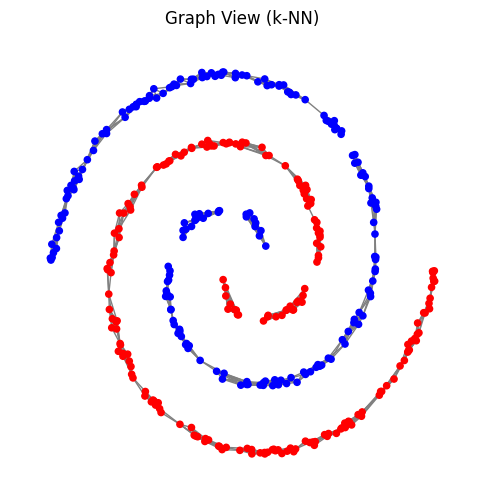

In [134]:
from sklearn.neighbors import kneighbors_graph
import networkx as nx

A = kneighbors_graph(dataset.x, n_neighbors=6, mode='connectivity')
G = nx.from_scipy_sparse_array(A)

pos = {i: (dataset.x[i, 0], dataset.x[i, 1]) for i in range(len(dataset.x))}
colors = ['blue' if label == 0 else 'red' for label in dataset.y]

fig, ax = plt.subplots(figsize=(6, 6))
nx.draw(G, pos, node_color=colors, node_size=20, edge_color='gray', ax=ax)
ax.set_title("Graph View (k-NN)")
ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")
ax.grid(True, alpha=0.50)

📌 For our spiral dataset, we'll assume a point cloud representation, where each input is simply a pair of coordinates in continuous space:

\begin{align*}
  x = (x_{0}, x_{1}) \in \mathbb{R}^{2}
\end{align*}

This feels like quite a natural representation for our data and encodes a low number of assumptions about the structure of the data (i.e. no grid, no toplogy, no structure). Whilst this encodes minimal assumptions, it means the model must learn things from scratch. Hence, we have defined our input:

\begin{align*}
  f : x \in \mathbb{R}^{2} \mapsto y \in \{0, 1\}
\end{align*}

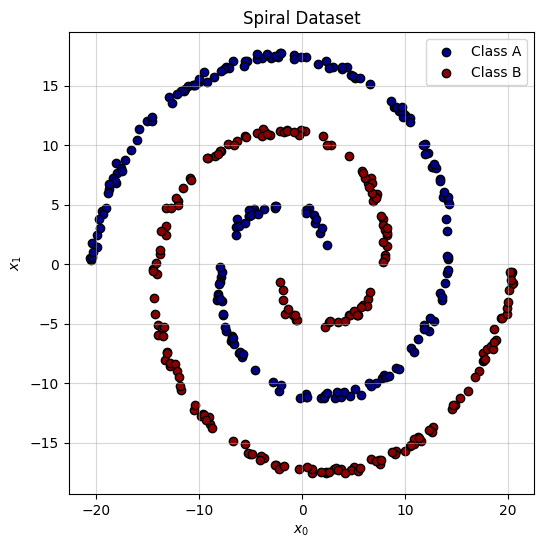

In [135]:
# visualize the dataset
fig, ax = plt.subplots(figsize=(6,6))
mask0 = dataset.y.squeeze() == 0
ax.scatter(dataset.x[mask0, 0], dataset.x[mask0, 1], color="darkblue", label="Class A", edgecolor="black")
mask1 = dataset.y.squeeze() == 1
ax.scatter(dataset.x[mask1, 0], dataset.x[mask1, 1], color="darkred", label="Class B", edgecolor="black")
ax.set_title("Spiral Dataset")
ax.grid(True, alpha=0.50)
ax.set_xlabel(r"$x_{0}$")
ax.set_ylabel(r"$x_{1}$")
ax.legend(loc="best")

💬 *What is your input data? How do you represent your inputs for your model? What assumptions does that representation encode?*

You might also extend this discussion on how we represent our data to include pre-processing steps such as normalization - these sort of steps adjust the structure and distribution of the input and interacts strongly with aspects of our modelling approach such as parameter initialization, which in turn influence what and how we learn.

<h3>Section 1D. Hypothesis Space & Network Structure</h3>

So far we have defined how the input and output data is represented, the next decision to make is:

> What sort of hypothesis space will we chose to learn this function?

Each representation implies different modeling strategies and thus hypothesis spaces:

*   Images $\rightarrow$ CNNs, Transformers, etc.
*   Point clouds $\rightarrow$ MLPs, Transformers, etc.
*   Graphs $\rightarrow$ GNNs, MPNNs, Transformers, etc.
*   Sequences $\rightarrow$ RNNs, Transformers, etc.

> 💡 Data representation is not just about data formatting - its a modeling choice - that has significant impacts on the learning process.

📌 We have been working so far with multi-layer perceptrons, this is a reasonable model class to use in this scenario. We want our MLP, $f$, to take as input the 2D coordinates:

\begin{align*}
  x = (x_{0}, x_{1}) \in \mathbb{R}^{2}
\end{align*}

and output a scalar value representing the class label.

\begin{align*}
  y \in \{0, 1\}
\end{align*}

We can define a network architecture that achieves this by abstracting our previous model architecture:

In [136]:
class PointClassificationMultiLayerPerceptron(MultiLayerPerceptron):
  def __init__(self, hidden_layers: int = 0, hidden_dim: int = 1):
    super(PointClassificationMultiLayerPerceptron, self).__init__(
      hidden_layers=hidden_layers,
      hidden_dim=hidden_dim,
      input_dim=2, # x
      output_dim=1, # y
    )

<h3>Section 1E. Training and evaluating the model</h3>

We can go ahead and train our model on our dataset; this might take some tweaking of the model and optimization process.

In [137]:
def training_loop(model, optimizer, loss_fn, dataset, steps):
  losses = []
  with tqdm(range(steps)) as pbar:
    for idx in pbar:
      optimizer.zero_grad()
      y_pred = model(dataset.x)
      loss = loss_fn(y_pred, dataset.y) # input=logits, target=labels
      losses.append(loss)
      loss.backward()
      optimizer.step()
      pbar.set_description(f"loss: {loss.item():.3f}")
    return model, torch.tensor(losses)

def plot_predictions(model, dataset):
    # evaluate model
    with torch.no_grad():
        logits = model(dataset.x)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float().cpu().numpy().squeeze()

    # Prepare data
    x_np = dataset.x.cpu().numpy()

    # Plot predictions (color = model prediction)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(x_np[:, 0], x_np[:, 1], c=preds, cmap="RdBu", edgecolor="k", label="Predictions")

    ax.set_title("Model Predictions (Hard Classification)")
    ax.set_xlabel(r"$x_0$")
    ax.set_ylabel(r"$x_1$")
    ax.set_aspect("equal")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.50)
    return fig, ax

In [138]:
dataset = SpiralDataset(N=200, noise=0.2)
model = PointClassificationMultiLayerPerceptron(hidden_layers=1, hidden_dim=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.BCEWithLogitsLoss()
model, losses = training_loop(model, optimizer, loss_fn, dataset, steps=500)

loss: 0.003: 100%|██████████| 500/500 [00:01<00:00, 295.55it/s]


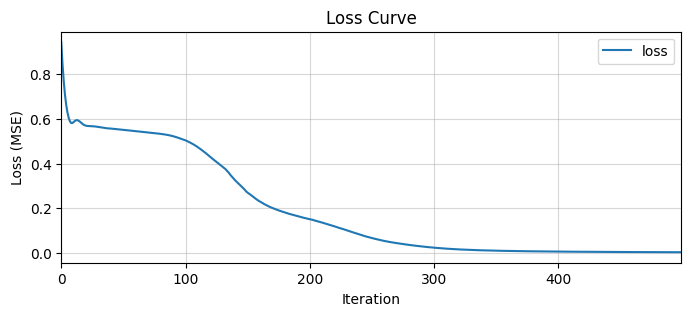

In [139]:
_ = plot_loss_curve(losses)

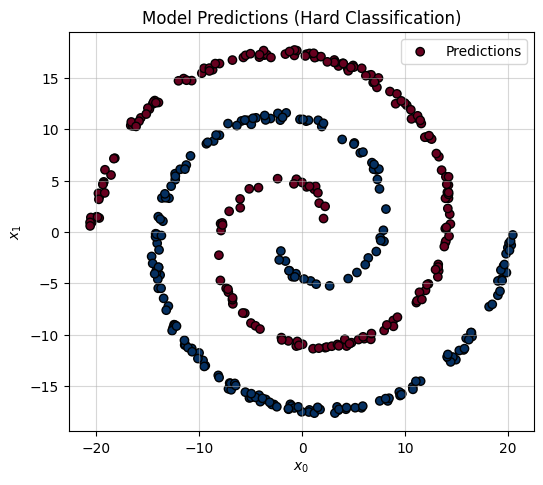

In [140]:
_ = plot_predictions(model, dataset)

We can visualize ...

In [34]:
def plot_spiral_classification(
  model,
  dataset,
  grid_range=(-25, 25),
  grid_size=500,
  levels=10,
):
  """
  Plot model predictions over the 2D spiral input space alongside the true data points.
  """
  model.eval()
  # Create meshgrid over specified range
  x_min, x_max = grid_range
  y_min, y_max = grid_range
  xx, yy = torch.meshgrid(
      torch.linspace(x_min, x_max, grid_size),
      torch.linspace(y_min, y_max, grid_size),
      indexing='ij'
  )
  grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)

  # Predict probabilities on grid
  with torch.no_grad():
      logits = model(grid)
      probs = torch.sigmoid(logits).reshape(xx.shape).cpu().numpy()

  # Plot contour of predicted probabilities
  fig, ax = plt.subplots(figsize=(6, 6))
  contour = ax.contourf(
      xx.cpu().numpy(), yy.cpu().numpy(), probs,
      levels=levels, cmap="RdBu", alpha=0.50
  )

  # Overlay true data points
  X_data = dataset.x.cpu().numpy()
  y_data = dataset.y.squeeze().cpu().numpy()
  ax.scatter(
      X_data[:, 0], X_data[:, 1],
      c=y_data, cmap="RdBu", edgecolor='k', label='Ground Truth'
  )

  ax.set_title("Spiral Classification")
  ax.set_xlim(x_min, x_max)
  ax.set_ylim(y_min, y_max)
  ax.set_xlabel(r"$x_0$")
  ax.set_ylabel(r"$x_1$")
  ax.set_aspect("equal")
  ax.legend(loc="best")
  plt.tight_layout()
  return fig, ax


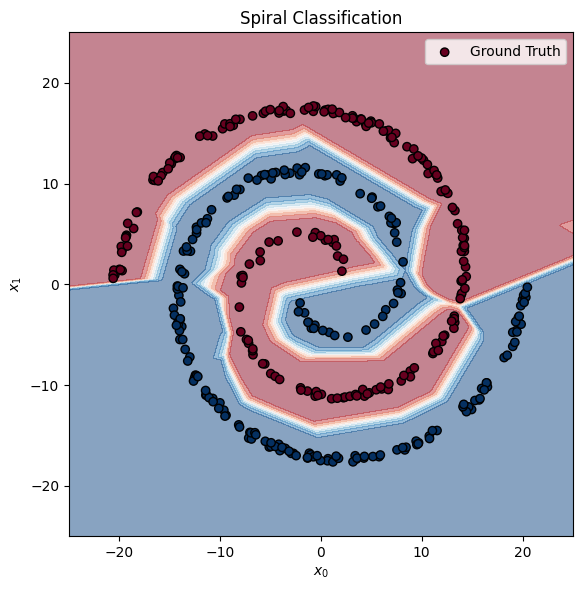

In [141]:
_ = plot_spiral_classification(model, dataset)

We can think about what we're asking the network to do here, and how this shapes what it learns. We can think of the network as learning a height function (a surface) over the 2D input plane:

\begin{align*}
  y = f(x_{0}, x_{1})
\end{align*}

In its raw form, the spirals are not linearly separable - theres no straight line we can draw to separate the classes. But, once we “lift” each point up to its height $y$, the spirals trace out two separate ridges on the surface. A simple horizontal cut—say at $y = 0.5$ now cleanly slices the surface into two regions, each containing exactly one spiral. This enables classification.



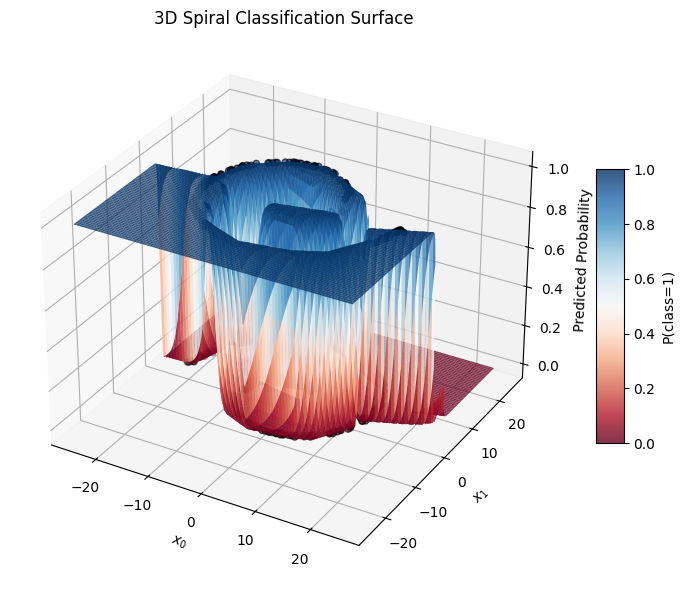

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def plot_spiral_classification_3d(
    model,
    dataset,
    grid_range=(-25, 25),
    grid_size=500,
    cmap="RdBu",
    alpha=0.8,
    point_size=20
):
    """
    Plot model predictions as a 3D surface over the 2D spiral input space,
    with true data points projected onto the surface.
    """
    model.eval()

    # 1) Create meshgrid
    x_min, x_max = grid_range
    y_min, y_max = grid_range
    xx = np.linspace(x_min, x_max, grid_size)
    yy = np.linspace(y_min, y_max, grid_size)
    XX, YY = np.meshgrid(xx, yy)
    grid = np.stack([XX.ravel(), YY.ravel()], axis=1)
    grid_t = torch.tensor(grid, dtype=torch.float32)

    # 2) Predict
    with torch.no_grad():
        logits = model(grid_t)
        probs = torch.sigmoid(logits).cpu().numpy().reshape(XX.shape)

    # 3) Plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")

    # Surface
    surf = ax.plot_surface(
        XX, YY, probs,
        rstride=5, cstride=5,
        cmap=cmap, edgecolor='none', alpha=alpha
    )

    # Scatter data points at their true probabilities (0 or 1)
    Xd = dataset.x.cpu().numpy()
    yd = dataset.y.squeeze().cpu().numpy()
    # Evaluate model at data points for actual height
    with torch.no_grad():
        dp = torch.sigmoid(model(dataset.x)).cpu().numpy().squeeze()
    ax.scatter(
        Xd[:, 0], Xd[:, 1], dp,
        c=yd, cmap="RdBu",
        edgecolor='k', s=point_size,
        label="Data Predictions"
    )

    ax.set_title("3D Spiral Classification Surface")
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    ax.set_zlabel("Predicted Probability")
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label="P(class=1)")
    ax.view_init(elev=30, azim=-60)
    plt.tight_layout()
    return fig, ax


fig, ax = plot_spiral_classification_3d(model, dataset)
plt.show()

In other words, rather than trying to draw a winding curve in the plane, the network learns to warp the data into the third dimension so that a single flat plane can separate the classes. This is exactly analogous to how, in 1D, we use ReLU “kinks” to approximate a curve by piecewise-linear segments: in 2D we use ReLU “creases” to build a surface whose level sets (planes $z = const.$) implement our decision boundary.








We can investigate what each neuron is doing...

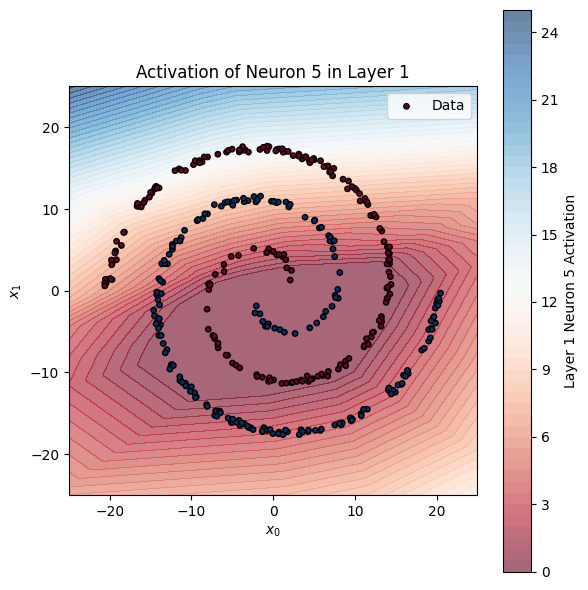

In [143]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_layer_neuron_response(
    model,
    dataset,
    layer_idx: int = 0,
    neuron_idx: int = 0,
    bounds: float = 25,
    resolution: int = 500,
    cmap: str = "RdBu",
    alpha: float = 0.6
):
    """
    Visualize the activation of a single neuron in a given PerceptronLayer
    over the 2D input plane.

    Args:
        model:          a MultiLayerPerceptron with .layers (ModuleList of PerceptronLayer)
        dataset:        object with .x (Tensor[N,2]) and .y (Tensor[N,1])
        layer_idx:      index into model.layers to probe
        neuron_idx:     which output neuron of that layer to visualize
        bounds:         axes range [-bounds, +bounds]
        resolution:     number of grid points per axis
        cmap:           heatmap colormap
        alpha:          heatmap transparency
    Returns:
        fig, ax:        Matplotlib figure and axes
    """
    assert hasattr(model, "layers"), "Model must have a .layers attribute"
    assert 0 <= layer_idx < len(model.layers), f"layer_idx out of range [0, {len(model.layers)-1}]"

    model.eval()
    # 1) build grid
    xs = torch.linspace(-bounds, bounds, resolution)
    ys = torch.linspace(-bounds, bounds, resolution)
    xx, yy = torch.meshgrid(xs, ys, indexing="ij")
    grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)  # [res^2, 2]

    # 2) forward through layers up to layer_idx
    with torch.no_grad():
        h = grid
        for i, layer in enumerate(model.layers):
            h = layer(h)
            if i == layer_idx:
                break
        activations = h[:, neuron_idx].reshape(xx.shape).cpu().numpy()

    # 3) plot
    fig, ax = plt.subplots(figsize=(6, 6))
    pcm = ax.contourf(
        xx.cpu().numpy(),
        yy.cpu().numpy(),
        activations,
        levels=50,
        cmap=cmap,
        alpha=alpha
    )
    fig.colorbar(pcm, ax=ax, label=f"Layer {layer_idx} Neuron {neuron_idx} Activation")

    # overlay data
    X_data = dataset.x.cpu().numpy()
    y_data = dataset.y.squeeze().cpu().numpy()
    ax.scatter(
        X_data[:, 0], X_data[:, 1],
        c=y_data, cmap=cmap,
        edgecolor="k", s=15, label="Data"
    )

    ax.set_title(f"Activation of Neuron {neuron_idx} in Layer {layer_idx}")
    ax.set_xlim(-bounds, bounds)
    ax.set_ylim(-bounds, bounds)
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    ax.set_aspect("equal")
    ax.legend(loc="best")
    plt.tight_layout()
    return fig, ax

fig, ax = plot_layer_neuron_response(
    model=model,
    dataset=dataset,
    layer_idx=1,
    neuron_idx=5,
)

In a $D$ dimensional input space, an MLP with ReLU activations alternates linear projections (affine mappings h=Wx+b) with folds (ReLU clamps along each coordinate’s hyperplane). This composition partitions $\mathbb{R}^{D}$ into a mosaic of convex polytopes, within each of which the network's overall mapping is exactly affine. By stacking many project-and-fold layers, deep nets “untangle” complex manifolds so that a single final hyperplane can cleanly separate the classes.

*An aside on manifolds...*

Real-world data—whether images, audio, or text—rarely fills its high-dimensional input space uniformly. Instead, it lies on a much lower-dimensional manifold, a “surface” defined by the data's true degrees of freedom.

Learning this manifold means discovering that hidden subspace so that the model focuses on the essential structure (e.g. semantic content or object shape) rather than irrelevant variation.

Deep networks uncover and flatten these manifolds by alternating linear projections (which lift data into new feature spaces) and nonlinear folds (ReLU or similar activations that crease along hyperplanes). Once the manifold is well represented, downstream tasks—classification, regression, or generation—boil down to simple geometric operations (like slicing with a hyperplane or interpolating along the surface) in that learned feature space.

<h3>Section 1F. How does class noise impact performance?</h3>

When class manifolds occupy distinct, well-separated regions—like two spirals winding far apart—a simple boundary suffices and even a linear classifier can separate them easily.

But when classes lie in close proximity or overlap on the manifold—like cars versus buses with similar features—the model must learn much more complex, nonlinear decision surfaces to untangle and distinguish them.

We can imagine we have noise in our dataset which means the decision boundary is much tighter. Or perhaps we don't have classes that we can truly separate.

In [144]:
dataset = SpiralDataset(N=500, noise=1.50)
model = PointClassificationMultiLayerPerceptron(hidden_layers=1, hidden_dim=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.BCEWithLogitsLoss()
model, losses = training_loop(model, optimizer, loss_fn, dataset, steps=500)

loss: 0.065: 100%|██████████| 500/500 [00:01<00:00, 278.33it/s]


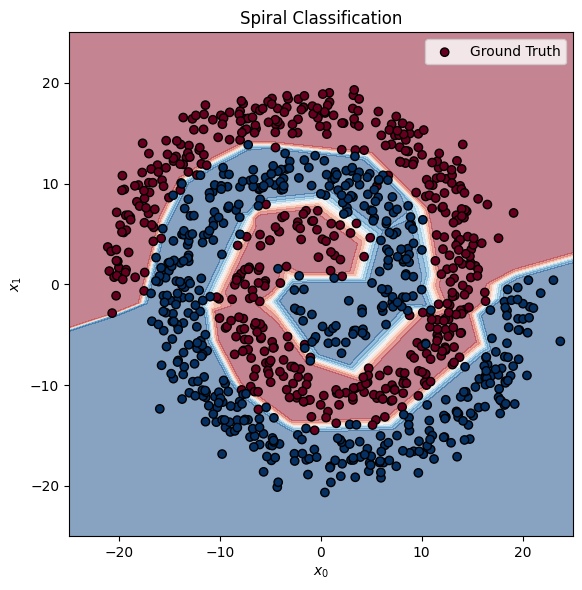

In [145]:
_ = plot_spiral_classification(model, dataset)

As before we can observe how the network learns to interpolate in regions where the model has been less constrained. When you remove a region from the training set, the MLP has no information about how the classes behave there...

💬 *Given the model learned is a function of the model x dataset x optimization, what techniques could you use to address this issue?*

<h3>Section 1G. How well does the model interpolate?</h3>

We can remove a portion of the training data to investigate how sensitive the model performance is to poor coverage of the underlying data manifold. We expect that without data to constrain the function behaviour within the removed region, the ability for the model to interpolate will depend on the geometry of the data manifold - for large changes we expect it to approximate poorly - for small changes we expect it to approximate reasonably.

In [146]:
# build dataset
dataset_full = SpiralDataset(N=500, noise=0.2)
x_full, y_full = dataset_full.x, dataset_full.y.squeeze()
theta = torch.atan2(x_full[:,1], x_full[:,0])

# pick a center and width
theta_c = 0.75  # radians
delta   = np.pi/10  # 22.5° on each side → 45° total wedge

# define masks
wedge_mask = (theta > theta_c - delta) & (theta < theta_c + delta)
class0 = (y_full == 0)
class1 = (y_full == 1)

# for *both* classes:
train_mask  = (class0 & ~wedge_mask) | class1
interp_mask = class0 & wedge_mask

# split the dataset up
class SubsetDataset:
    def __init__(self, x, y):
        self.x = x
        self.y = y

train_ds  = SubsetDataset(dataset_full.x[train_mask],  dataset_full.y[train_mask])
interp_ds = SubsetDataset(dataset_full.x[interp_mask], dataset_full.y[interp_mask])

# train a model
model     = PointClassificationMultiLayerPerceptron(hidden_layers=1, hidden_dim=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn   = nn.BCEWithLogitsLoss()
model, losses = training_loop(model, optimizer, loss_fn, train_ds, steps=500)

loss: 0.002: 100%|██████████| 500/500 [00:01<00:00, 262.68it/s]


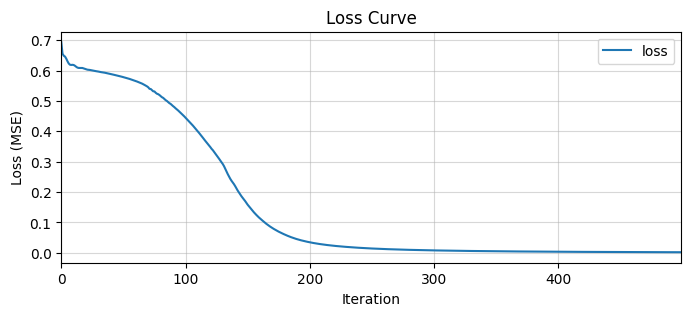

In [147]:
_ = plot_loss_curve(losses)

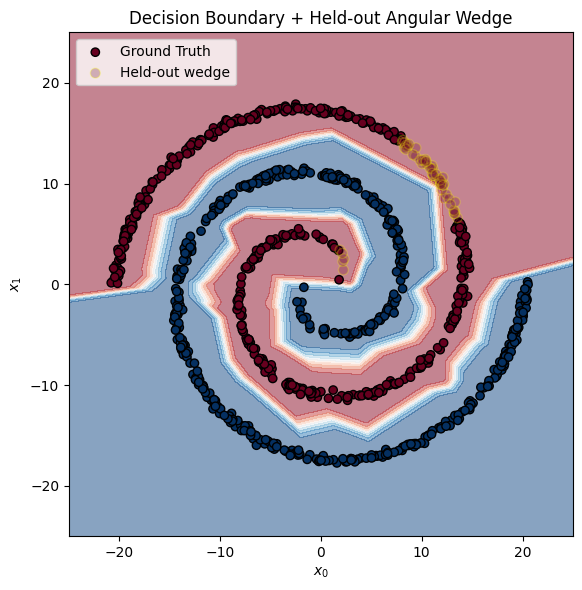

In [148]:
fig, ax = plot_spiral_classification(
    model,
    train_ds,
    grid_range=(-25,25),
    grid_size=500,
    levels=10
)
X_int = interp_ds.x.cpu().numpy()
y_int = interp_ds.y.squeeze().cpu().numpy()
ax.scatter(
    X_int[:, 0], X_int[:, 1],
    c=y_int, cmap="RdBu",
    marker="o", edgecolor="yellow",
    s=50, label="Held-out wedge", alpha=0.25
)
ax.set_title("Decision Boundary + Held-out Angular Wedge")
ax.legend(loc="upper left")
plt.show()

<h3>Section 1H. How well does the model extrapolate?</h3>

Because ReLU networks partition space into a finite set of polytopes defined by training-time hyperplanes, any point outside the convex hull of your data simply lands in one of those outermost pieces. The network then applies the same learned affine parameters on that piece, which can lead to constant or unbounded growth (depending on the weights) and typically very poor accuracy.

In short, without explicit inductive biases or data covering the extrapolation region, deep nets have no guarantees and tend to perform arbitrarily poorly when asked to extrapolate.

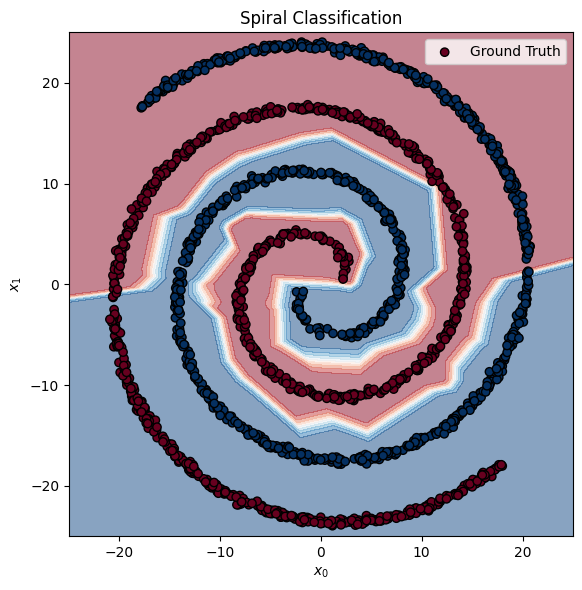

In [149]:
# build dataset
dataset_extrap = SpiralDataset(N=1000, noise=0.2, ratio=1.25)

# plot
fig, ax = plot_spiral_classification(
    model,
    dataset_extrap,
    grid_range=(-25,25),
    grid_size=500,
    levels=10
)

💬 *Given the model learned is a function of the model x dataset x optimization, what techniques could you use to address this issue?*

<h3>Section 1I. How well does the model extrapolate? Again.</h3>

When you deploy a model on data whose distribution differs from what it saw during training — whether that's a different input range, noise level, or entirely new patterns — you have zero theoretical guarantees that its piecewise-affine approximation will hold.

In practice, the network will simply apply its learned affine maps to whichever region of its input tessellation the new points fall into, often resulting in unpredictable or completely wrong outputs under distribution shift.:

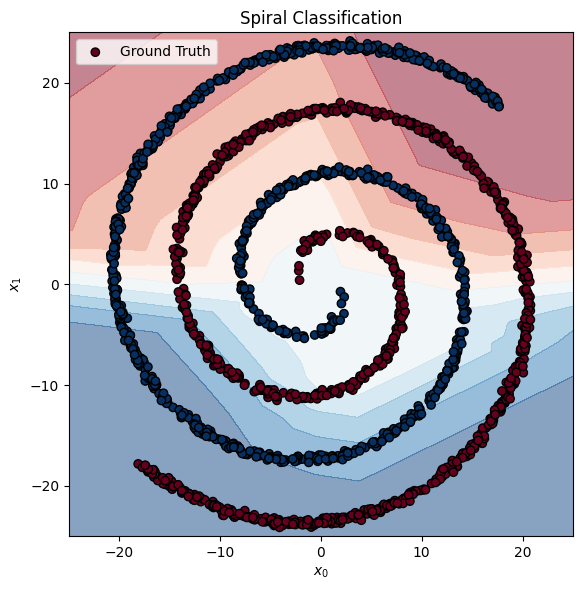

In [188]:
# build dataset
dataset_ood = SpiralDataset(N=1000, noise=0.2, ratio=1.25)

# flip spiral
dataset_ood.x[:,0] *= -1 # flip x-coord

# plot
fig, ax = plot_spiral_classification(
    model,
    dataset_ood,
    grid_range=(-25,25),
    grid_size=500,
    levels=10
)

💬 *Given the model learned is a function of the model x dataset x optimization, what techniques could you use to address this issue?*

One approach to reduce this issue might be data augmentation. Data augmentation refers to the practice of artificially expanding the dataset (by applying label-preserving transformations) to existing examples. The aim would be to expose the model to a wider data distribution so we hope we are more likely to be operating in the interpolation regime during inference.

Because our MLP only sees one $(x_{0}, x_{1})$ at a time, any augmentation that doesn't preserve the underlying mapping $f(x) \rightarrow y$ will effectively teach it a different function each time. For the spiral, a global rotation or large affine transform will sweep points from one arm into the other's territory—so the same augmented coordinate can require opposite labels.

Since, the network has no access to the “shape” of the spiral or its loops, only the local coordinates, and so it can't reconcile those contradictions without global context or a label-preserving augmentation scheme.










<h3>Section 1G. Mini-batch Gradient Descent</h3>

Mini-batch gradient descent is an optimization technique that updates model parameters using the average gradient computed over a small, randomly sampled subset of the training data (the "mini-batch") at each step.

By processing, say, 32 - 256 examples at once, it leverages parallel hardware for efficiency, smooths out the high variance of per-example updates found in pure stochastic gradient descent, and still retains enough randomness to help escape poor local minima—unlike full batch methods, which compute gradients over the entire dataset and can be prohibitively slow or memory-intensive on large datasets.

When we perform the gradient descent step:

\begin{align*}
\theta := \theta - \eta \cdot \nabla_\theta \mathcal{L}(f_\theta(x), y)
\end{align*}

We compute the loss across a subset of the dataset per step:

\begin{align*}
\mathcal{L}(\theta)
= \frac{1}{M} \sum_{i=1}^{M} \left( f_\theta(x_i) - y_i \right)^2
\end{align*}

where:

\begin{align*}
    \mathcal{D} = \left\{ (\mathcal{X}_{i}, \mathcal{Y}_{i}) \right\}_{i=0}^{M} \subseteq \left\{ (\mathcal{X}_{i}, \mathcal{Y}_{i}) \right\}_{i=0}^{N}
\end{align*}

As your batch size decreases your approximation of the loss landscape becomes worse, and thus your gradient becomes worse. This acts as a regularizing effect during training potentially reducing over-fitting, on the extreme end it can make training extremely difficult.

> You're blindfolded and attempting to navigate downhill and the landscape changes each step you take.

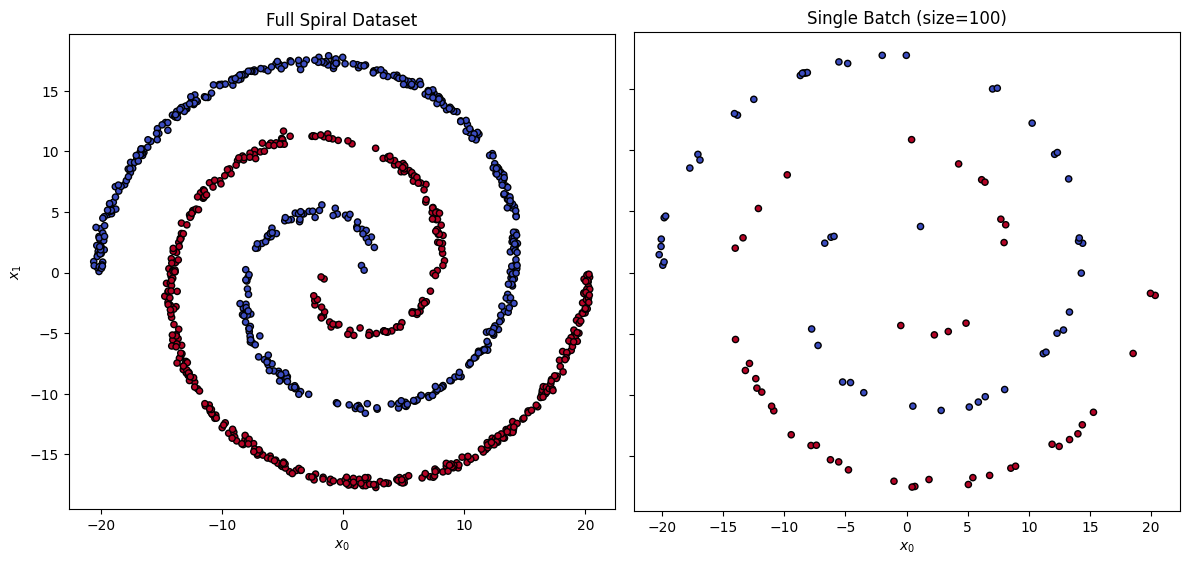

In [179]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# 1) Instantiate your dataset
dataset = SpiralDataset(N=500, noise=0.20)

# 2) Prepare a dataloader (e.g. batch size 100)
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 3) Grab one batch
batch_x, batch_y = next(iter(dataloader))

# 4) Convert to NumPy for plotting
full_x = dataset.x.cpu().numpy()
full_y = dataset.y.squeeze().cpu().numpy()
bx     = batch_x.cpu().numpy()
by     = batch_y.squeeze().cpu().numpy()

# 5) Plot
fig, (ax_full, ax_batch) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Full dataset
ax_full.scatter(full_x[:, 0], full_x[:, 1], c=full_y,
                cmap="coolwarm", edgecolor="k", s=20)
ax_full.set_title("Full Spiral Dataset")
ax_full.set_xlabel("$x_0$")
ax_full.set_ylabel("$x_1$")
ax_full.set_aspect("equal")

# Single batch
ax_batch.scatter(bx[:, 0], bx[:, 1], c=by,
                 cmap="coolwarm", edgecolor="k", s=20)
ax_batch.set_title(f"Single Batch (size={batch_size})")
ax_batch.set_xlabel("$x_0$")
ax_batch.set_aspect("equal")

plt.tight_layout()
plt.show()


We need to modify our training loop slightly to handle using batches, we will use the `DataLoader` class to handle this for us...

In [180]:
# define a training loop
def training_loop_epochs(model, optimizer, loss_fn, dataloader, epochs):
  losses = []
  with tqdm(range(epochs)) as pbar:
    for idx in pbar:
      for jdx, batch in enumerate(dataloader): # each step represents a subset of the dataset
        optimizer.zero_grad()
        x, y = batch
        y_pred = model(x)
        # print(jdx, x.shape, y.shape)
        loss = loss_fn(y_pred, y)
        losses.append(loss)
        loss.backward()
        optimizer.step()
        pbar.set_description(f"[Epoch:{idx+1}/{epochs}] loss @ step {jdx}: {loss.item():.3f}")
  return model, torch.tensor(losses)

We compute the number of epochs by dividing our desired total update count `n_steps` by the number of batches per epoch `N//bs`, so that we perform approximately the same number of update steps as during previous training. Explore how the batch size impacts the performance of the model.

In [187]:
from torch.utils.data import DataLoader

dataset = SpiralDataset(N=200, noise=0.20)

# compute the equivalent number of epochs to use
n_steps = 500
n_samples = len(dataset) # should be 2*N
bs = 32
n_epochs = n_steps // (n_samples // bs)

dataloader = DataLoader(dataset, batch_size=bs, shuffle=False, drop_last=True)
model = PointClassificationMultiLayerPerceptron(hidden_layers=1, hidden_dim=10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.BCEWithLogitsLoss()
model, losses = training_loop_epochs(model, optimizer, loss_fn, dataloader, epochs=n_epochs)

[Epoch:41/41] loss @ step 11: 0.531: 100%|██████████| 41/41 [00:02<00:00, 15.67it/s]


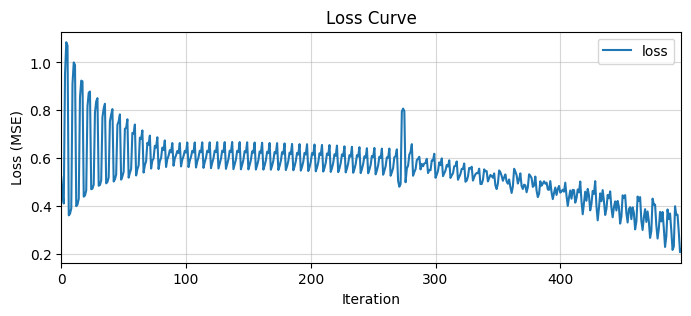

In [185]:
_ = plot_loss_curve(losses)

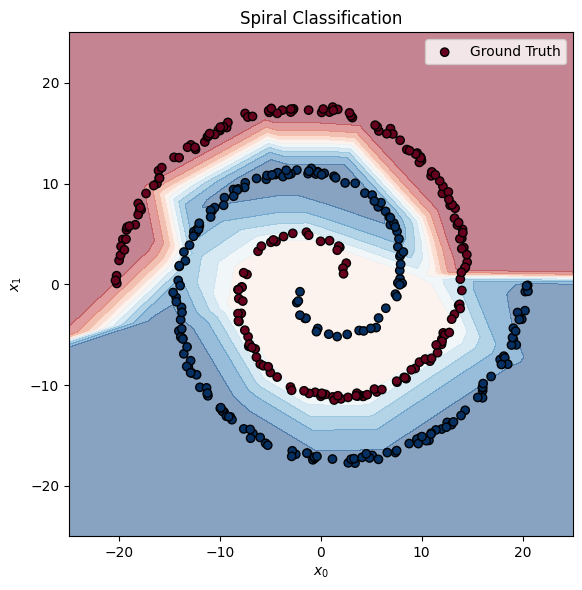

In [186]:
_ = plot_spiral_classification(model, dataset)

<h2>Section 2. Raster-based Classification</h2>

Instead of treating each $(x_0,x_1)$ as an independent sample, we can **rasterize** the entire spiral into a 2D grid (an image) and feed that into a convolutional or fully-connected network.  

By binning the points into pixels - e.g. one channel for spiral A density, another for spiral B—we give the model **global context**: it now “sees” the whole shape of both spirals at once, rather than only local coordinates.

Of course, rasterization also introduces trade-offs. Discretizing into a fixed grid can blur fine details or introduce aliasing unless you choose a sufficiently high resolution.

In [ ]:
# rasterize
rgb, extent = rasterize_by_class(dataset.x, dataset.y, bins=50)

# plot image
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(rgb, extent=extent)
ax.set_title("Rasterized Spiral (Image-like)")
ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")
ax.grid(True, alpha=0.50)

We then need to define the input and outputs to our function.

We can write a `Dataset` that handles this for us.

In [269]:
import torch
import numpy as np

class RasterizedSpiralDataset(SpiralDataset):
  """
  Generates a rasterized 2D spiral dataset with two arms (binary classification).
  """
  def __init__(self, bins: int, *args, **kwargs):
    super(RasterizedSpiralDataset, self).__init__(*args, **kwargs)
    self.bins = bins

    self.img = None
    self.mask = None

  def __len__(self) -> int:
    return 1

  def __getitem__(self, index: int) -> tuple:
    if self.img is None:
      # bounds of raster
      x0_min, x0_max = self.x[:,0].min(), self.x[:,0].max()
      x1_min, x1_max = self.x[:,1].min(), self.x[:,1].max()

      # Separate class 0 and class 1
      X0 = self.x[self.y.squeeze() == 0]
      X1 = self.x[self.y.squeeze() == 1]

      # Rasterize using 2D histogram
      hist0, _, _ = np.histogram2d(X0[:,0], X0[:,1], bins=self.bins, range=[[x0_min, x0_max], [x1_min, x1_max]])
      hist1, _, _ = np.histogram2d(X1[:,0], X1[:,1], bins=self.bins, range=[[x0_min, x0_max], [x1_min, x1_max]])

      # Normalize histograms to [0,1] for color intensity
      hist0 /= hist0.max()
      hist1 /= hist1.max()

      # Combine into RGB image: Red for class 1, Blue for class 0
      img = np.zeros((self.bins, self.bins, 3))
      img[..., 0] = hist1.T  # Red channel
      img[..., 2] = hist0.T  # Blue channel

      # build mask: whichever class has higher density
      mask = np.zeros((self.bins, self.bins), dtype=np.int64)
      mask[hist0.T > hist1.T] = 1
      mask[hist1.T > hist0.T] = 2

      # convert as torch tensors
      img  = torch.from_numpy(img).to(dtype=torch.float) # H,W,C
      mask = torch.from_numpy(mask).to(dtype=torch.float) # H,W

      # flatten and cache
      self.img = img.flatten()
      self.mask = mask.flatten()

    return self.img, self.mask

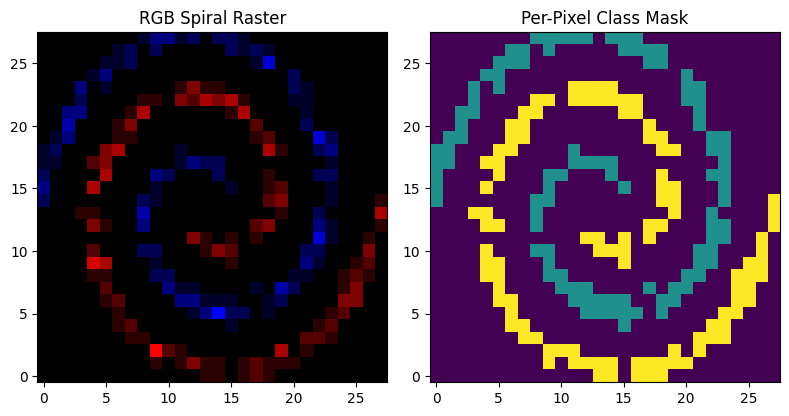

In [270]:
# define the dataset & rasterize
dataset = RasterizedSpiralDataset(N=200, noise=0.5, bins=28)
img, mask = dataset.__getitem__(0)

# plot
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4))
ax1.imshow(img.reshape((28,28,3)), origin='lower')
ax1.set_title("RGB Spiral Raster")
ax2.imshow(mask.reshape((28,28)), origin='lower')
ax2.set_title("Per-Pixel Class Mask")
plt.tight_layout()
plt.show()

We have rasterized our spiral into a $H \times W \times C$ image, we have flattened this into a $HW \times C$ vector.

In [271]:
img.shape

torch.Size([2352])

In [272]:
mask.shape

torch.Size([784])

We might aim to use the same model ... how to define the input and output shape in terms of x in R^...

We can then design a model that takes in this flattened set of pixels and outputs a corresponding flattened set of pixels.

In [282]:
class FlatMLPSegmentation(nn.Module):
    def __init__(self, bins, hidden_dim=256):
        super().__init__()
        self.input_dim = 3 * bins * bins
        self.net = nn.Sequential(
            nn.Linear(self.input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, bins * bins)
        )

    def forward(self, img):
        # img: [B,3,H,W]
        B = img.size(0)
        x = img.view(B, -1)        # flatten to [B, 3*H*W]
        return self.net(x)         # [B, num_classes]

In [283]:
# define a training loop
def training_loop_epochs(model, optimizer, loss_fn, dataloader, epochs):
  losses = []
  with tqdm(range(epochs)) as pbar:
    for idx in pbar:
      for jdx, batch in enumerate(dataloader): # each step represents a subset of the dataset
        optimizer.zero_grad()
        x, y = batch
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        losses.append(loss)
        loss.backward()
        optimizer.step()
        pbar.set_description(f"[Epoch:{idx+1}/{epochs}] loss @ step {jdx}: {loss.item():.3f}")
  return model, torch.tensor(losses)

In [291]:
# 1) Instantiate the raster dataset instead of the point dataset
bins = 28
raster_ds = RasterizedSpiralDataset(N=500, noise=0.2, bins=bins)

# 2) Create a DataLoader that yields (img, mask) of shape [1,3,H,W] and [1,H,W]
dataloader = DataLoader(raster_ds, batch_size=1, shuffle=False)

# 3) Instantiate the segmentation model, loss, and optimizer
model     = FlatMLPSegmentation(bins=bins, hidden_dim=512)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 4) Run the training loop
model, losses = training_loop_epochs(
    model,
    optimizer,
    criterion,
    dataloader,
    epochs=100
)

[Epoch:100/100] loss @ step 0: 1616.745: 100%|██████████| 100/100 [00:03<00:00, 31.79it/s]


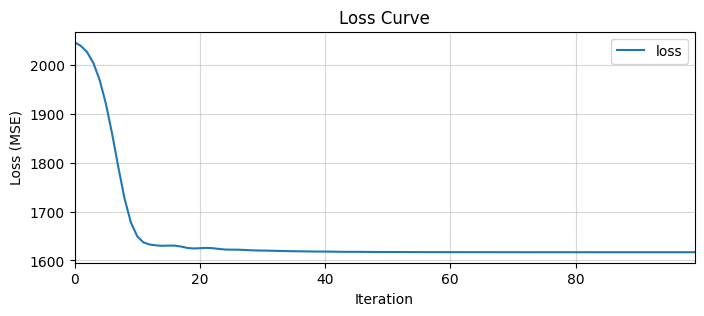

In [292]:
_ = plot_loss_curve(losses)

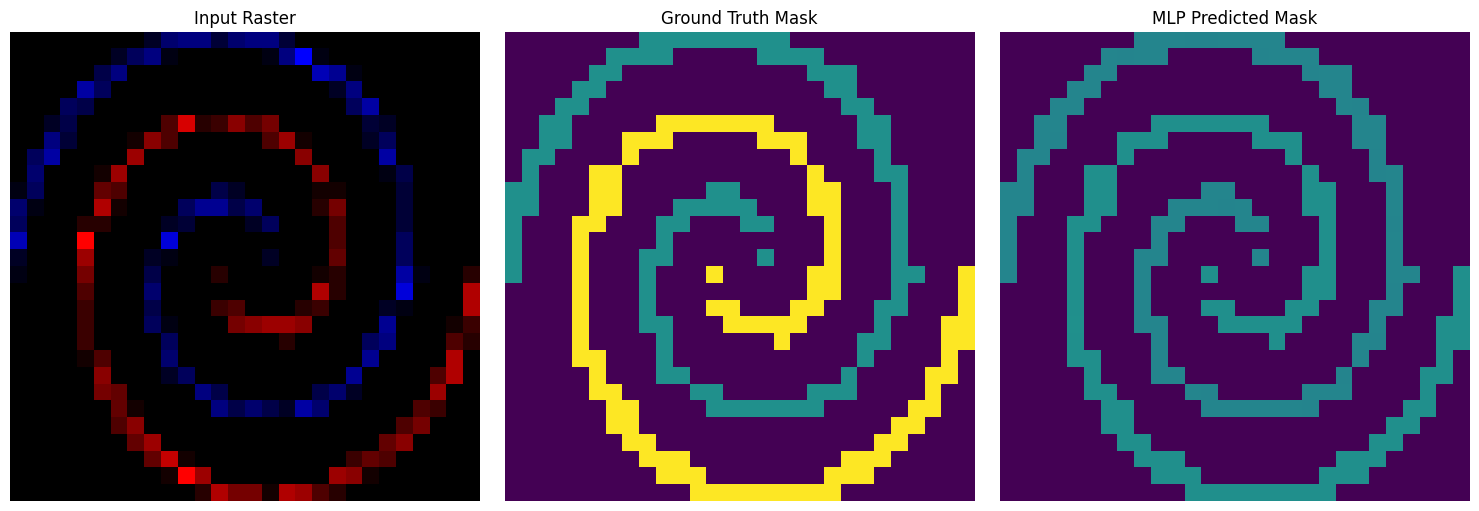

In [302]:
# 4) Inference & plotting
model.eval()
with torch.no_grad():
    img_flat, mask_flat = next(iter(dataloader))
    logits = model(img_flat)                         # [1,3,H*W]
    preds  = logits   # [H*W]

# reshape back to images
img   = img_flat.view(bins, bins, 3).cpu().numpy()  # [H,W,3]
gt    = mask_flat.view(bins, bins).cpu().numpy()                   # [H,W]
pred  = preds.view(bins, bins).cpu().numpy()                       # [H,W]

# plot side by side
fig, axes = plt.subplots(1,3,figsize=(15,5))
axes[0].imshow(img, origin='lower')
axes[0].set_title("Input Raster")
axes[1].imshow(gt, origin='lower', vmin=0, vmax=2)
axes[1].set_title("Ground Truth Mask")
axes[2].imshow(pred, origin='lower', vmin=0, vmax=2)
axes[2].set_title("MLP Predicted Mask")
for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()

<h2>Conclusion</h2>

Problem formulation profoundly influences model design and performance.

Input representation encodes inductive biases that shape what a model can easily learn.

Interpolation vs. extrapolation must be handled differently—augmented or structured data can help.

Visualization (activations, surfaces, decision boundaries) is a powerful tool to interpret learning behaviour.

